# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'calibration.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
plotErrorBars = False
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
]
intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## 2kr

In [8]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.995992,0.989980,0.981964,0.975952,0.981964,0.993988,0.985972,0.997996,0.979960,0.995992,0.987976,0.008016,0.002004,-0.006012,-0.012024,-0.006012,0.006012,-0.002004,0.010020,-0.008016,0.008016
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,0.997996,0.985972,0.989980,0.997996,1.000000,0.991984,0.997996,1.000000,1.000000,0.997996,0.995992,0.002004,-0.010020,-0.006012,0.002004,0.004008,-0.004008,0.002004,0.004008,0.004008,0.002004
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,0.995992,0.991984,0.993988,1.000000,0.995992,0.991984,0.989980,0.993988,0.995992,0.987976,0.993788,0.002204,-0.001804,0.000200,0.006212,0.002204,-0.001804,-0.003808,0.000200,0.002204,-0.005812
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,0.993988,0.997996,0.993988,1.000000,0.997996,1.000000,0.995992,1.000000,0.991984,0.997996,0.996994,-0.003006,0.001002,-0.003006,0.003006,0.001002,0.003006,-0.001002,0.003006,-0.005010,0.001002
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,0.981964,0.993988,0.987976,0.987976,0.997996,0.979960,0.993988,0.971944,1.000000,0.991984,0.988778,-0.006814,0.005210,-0.000802,-0.000802,0.009218,-0.008818,0.005210,-0.016834,0.011222,0.003206
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1.000000,0.997996,0.997996,0.997996,0.993988,1.000000,0.997996,0.997996,1.000000,1.000000,0.998397,0.001603,-0.000401,-0.000401,-0.000401,-0.004409,0.001603,-0.000401,-0.000401,0.001603,0.001603
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.000000,0.987976,1.000000,1.000000,0.993988,1.000000,0.995992,0.997996,0.995992,0.995992,0.996794,0.003206,-0.008818,0.003206,0.003206,-0.002806,0.003206,-0.000802,0.001202,-0.000802,-0.000802
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997996,1.000000,1.000000,0.999800,0.000200,0.000200,0.000200,0.000200,0.000200,0.000200,0.000200,-0.001804,0.000200,0.000200
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,0.943888,0.923848,0.895792,0.829659,0.729459,0.749499,0.911824,0.853707,0.835671,0.865731,0.853908,0.089980,0.069940,0.041884,-0.024248,-0.124449,-0.104409,0.057916,-0.000200,-0.018236,0.011824


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.423046,-0.493988,0.287976,0.120842,0.165731,0.26994,0.088377,0.118036,-0.024248,-0.001804,-0.063928,-0.029459,-0.004609,-0.041082,0.023447,0.027054,0.195503,0.039110,0.057821,-0.131743,-0.235666,0.065677,-0.080700,0.126162,-0.043168,0.007004
Mean (Qi),0.96394,-0.030874,0.017998,0.007553,0.010358,0.016871,0.005524,0.007377,-0.001516,-0.000113,-0.003995,-0.001841,-0.000288,-0.002568,0.001465,0.001691,0.012219,0.002444,0.003614,-0.008234,-0.014729,0.004105,-0.005044,0.007885,-0.002698,0.000438
SSQ,,,,,,,,,,,,,,,,,0.014348,0.006763,0.004377,0.020847,0.026452,0.022142,0.012210,0.005931,0.003198,0.007062


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.152515,0.051831,0.009127,0.017167,0.045542,0.004882,0.008708,0.000367,0.000002,0.002554,0.000542,0.000013,0.001055,0.000344,0.000457,0.123329
Variation,0.364488,0.123869,0.021811,0.041026,0.108839,0.011666,0.02081,0.000878,0.000005,0.006104,0.001296,0.000032,0.002521,0.000821,0.001093,0.418436
Variation%,36.45%,12.39%,2.18%,4.10%,10.88%,1.17%,2.08%,0.09%,0.00%,0.61%,0.13%,0.00%,0.25%,0.08%,0.11%,29.47%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.026301,0.022572,0.012126,0.014931,0.021444,0.010097,0.01195,0.003058,0.00446,0.000578,0.002732,0.004285,0.002005,0.006038,0.006264
CI- Qi (95.00%),-0.035447,0.013425,0.00298,0.005785,0.012298,0.000951,0.002804,-0.006089,-0.004686,-0.008569,-0.006414,-0.004861,-0.007141,-0.003108,-0.002882
Distance (Qi),0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146,0.009146
Zero Included,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
CI+ Variation,0.26451,0.194811,0.056221,0.085248,0.175838,0.03898,0.054607,0.003575,0.007607,0.000128,0.002854,0.007021,0.001538,0.013943,0.015003
CI- Variation,0.48046,0.068921,0.003395,0.012797,0.057833,0.000345,0.003007,0.014175,0.008396,0.028074,0.015732,0.009036,0.019497,0.003693,0.003176
CI Distance (Variation),0.21595,0.12589,0.052827,0.07245,0.118006,0.038634,0.0516,0.0106,0.000788,0.027946,0.012878,0.002015,0.017959,0.01025,0.011827


SSE = 0.1233292235774154
SST = 0.4184360454375685
Error variance = 0.0008564529415098291
Unexplained Variation = 29.47%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,529.0,505.0,543.0,473.0,529.0,543.0,542.0,521.0,592.0,509.0,528.6,0.4,-23.6,14.4,-55.6,0.4,14.4,13.4,-7.6,63.4,-19.6
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,305.0,319.0,376.0,349.0,346.0,378.0,352.0,384.0,317.0,357.0,348.3,-43.3,-29.3,27.7,0.7,-2.3,29.7,3.7,35.7,-31.3,8.7
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,571.0,559.0,574.0,597.0,620.0,649.0,574.0,546.0,578.0,590.0,585.8,-14.8,-26.8,-11.8,11.2,34.2,63.2,-11.8,-39.8,-7.8,4.2
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,358.0,428.0,346.0,376.0,409.0,376.0,407.0,352.0,375.0,347.0,377.4,-19.4,50.6,-31.4,-1.4,31.6,-1.4,29.6,-25.4,-2.4,-30.4
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,434.0,440.0,473.0,411.0,462.0,468.0,492.0,492.0,466.0,467.0,460.5,-26.5,-20.5,12.5,-49.5,1.5,7.5,31.5,31.5,5.5,6.5
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,294.0,273.0,274.0,348.0,316.0,278.0,333.0,310.0,339.0,258.0,302.3,-8.3,-29.3,-28.3,45.7,13.7,-24.3,30.7,7.7,36.7,-44.3
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,520.0,603.0,566.0,621.0,613.0,592.0,579.0,556.0,590.0,596.0,583.6,-63.6,19.4,-17.6,37.4,29.4,8.4,-4.6,-27.6,6.4,12.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,467.0,420.0,406.0,487.0,393.0,445.0,381.0,436.0,416.0,406.0,425.7,41.3,-5.7,-19.7,61.3,-32.7,19.3,-44.7,10.3,-9.7,-19.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1389.0,1464.0,1227.0,1613.0,1858.0,1573.0,1524.0,1911.0,1811.0,1546.0,1591.6,-202.6,-127.6,-364.6,21.4,266.4,-18.6,-67.6,319.4,219.4,-45.6


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,18006.7,10782.3,-516.1,3104.3,-557.5,-380.1,2438.7,852.1,1259.1,108.1,228.9,938.7,-37.1,284.5,610.5,553.7,-560055.710000,-744122.110000,-189186.110000,550454.590000,1.908252e+06,212490.490000,532201.790000,-1.428699e+06,155039.590000,-436375.310000
Mean (Qi),1125.41875,673.89375,-32.25625,194.01875,-34.84375,-23.75625,152.41875,53.25625,78.69375,6.75625,14.30625,58.66875,-2.31875,17.78125,38.15625,34.60625,-35003.481875,-46507.631875,-11824.131875,34403.411875,1.192657e+05,13280.655625,33262.611875,-8.929368e+04,9689.974375,-27273.456875
SSQ,,,,,,,,,,,,,,,,,185652.410000,130076.210000,315587.210000,110449.810000,5.481898e+05,115071.010000,147574.410000,3.758976e+05,166092.810000,93033.610000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,72661245.80625,166474.50625,6022924.05625,194253.90625,90297.50625,3717036.05625,453796.50625,990833.00625,7303.50625,32747.00625,550723.55625,860.25625,50587.65625,232943.90625,191614.80625,2187624.9
Variation,0.829928,0.001901,0.068793,0.002219,0.001031,0.042456,0.005183,0.011317,0.000083,0.000374,0.00629,0.00001,0.000578,0.002661,0.002189,87551266.94375
Variation%,82.99%,0.19%,6.88%,0.22%,0.10%,4.25%,0.52%,1.13%,0.01%,0.04%,0.63%,0.00%,0.06%,0.27%,0.22%,2.50%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),693.153849,-12.996151,213.278849,-15.583651,-4.496151,171.678849,72.516349,97.953849,26.016349,33.566349,77.928849,16.941349,37.041349,57.416349,53.866349
CI- Qi (95.00%),654.633651,-51.516349,174.758651,-54.103849,-43.016349,133.158651,33.996151,59.433651,-12.503849,-4.953849,39.408651,-21.578849,-1.478849,18.896151,15.346151
Distance (Qi),38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197,38.520197
Zero Included,False,False,False,False,False,False,False,False,True,True,False,True,True,False,False
CI+ Variation,0.878045,0.000309,0.083129,0.000444,0.000037,0.053863,0.00961,0.017535,0.001237,0.002059,0.011098,0.000525,0.002507,0.006025,0.005303
CI- Variation,0.783167,0.00485,0.055813,0.00535,0.003382,0.032404,0.002112,0.006455,0.000286,0.000045,0.002838,0.000851,0.000004,0.000653,0.00043
CI Distance (Variation),0.094878,0.004541,0.027316,0.004906,0.003345,0.021459,0.007498,0.011079,0.000951,0.002014,0.00826,0.000326,0.002503,0.005372,0.004872


SSE = 2187624.9
SST = 87551266.94375
Error variance = 15191.839583333332
Unexplained Variation = 2.50%

####################################

2^k*r analysis for the Broadcast time needed to reach the 10th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,10.0,8.0,7.0,8.0,11.0,8.0,7.0,8.0,11.0,7.0,8.5,1.5,-0.5,-1.5,-0.5,2.5,-0.5,-1.5,-0.5,2.5,-1.5
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,9.0,6.0,7.0,8.0,10.0,7.0,9.0,12.0,9.0,7.0,8.4,0.6,-2.4,-1.4,-0.4,1.6,-1.4,0.6,3.6,0.6,-1.4
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,9.0,5.0,8.0,16.0,8.0,10.0,8.0,9.0,10.0,11.0,9.4,-0.4,-4.4,-1.4,6.6,-1.4,0.6,-1.4,-0.4,0.6,1.6
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,21.0,8.0,8.0,9.0,13.0,7.0,8.0,8.0,8.0,6.0,9.6,11.4,-1.6,-1.6,-0.6,3.4,-2.6,-1.6,-1.6,-1.6,-3.6
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,16.0,15.0,31.0,17.0,15.0,16.0,17.0,15.0,9.0,16.0,16.7,-0.7,-1.7,14.3,0.3,-1.7,-0.7,0.3,-1.7,-7.7,-0.7
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,13.0,10.0,17.0,18.0,15.0,17.0,23.0,23.0,17.0,23.0,17.6,-4.6,-7.6,-0.6,0.4,-2.6,-0.6,5.4,5.4,-0.6,5.4
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,22.0,17.0,16.0,17.0,16.0,15.0,17.0,17.0,15.0,15.0,16.7,5.3,0.3,-0.7,0.3,-0.7,-1.7,0.3,0.3,-1.7,-1.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,11.0,15.0,16.0,18.0,18.0,13.0,17.0,15.0,15.0,17.0,15.5,-4.5,-0.5,0.5,2.5,2.5,-2.5,1.5,-0.5,-0.5,1.5
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,1.9,-0.9,-0.9,-0.9,-0.9,-0.9,-0.9,-0.9,2.1,2.1,2.1


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,115.2,-89.6,32.8,0.2,-0.8,-28.4,0.2,-0.4,-3.0,1.6,-0.6,5.4,2.4,3.0,-2.2,2.6,40.38000,-255.22000,178.88,123.98000,15.38000,-133.92,82.88,67.280,-150.320,30.6800
Mean (Qi),7.2,-5.6,2.05,0.0125,-0.05,-1.775,0.0125,-0.025,-0.1875,0.1,-0.0375,0.3375,0.15,0.1875,-0.1375,0.1625,2.52375,-15.95125,11.18,7.74875,0.96125,-8.37,5.18,4.205,-9.395,1.9175
SSQ,,,,,,,,,,,,,,,,,207.12000,93.32000,248.12,123.92000,95.12000,23.72,43.12,56.320,119.520,62.5200


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,5017.6,672.4,0.025,0.4,504.1,0.025,0.1,5.625,1.6,0.225,18.225,3.6,5.625,3.025,4.225,1072.8
Variation,0.68644,0.091989,0.000003,0.000055,0.068964,0.000003,0.000014,0.00077,0.000219,0.000031,0.002493,0.000493,0.00077,0.000414,0.000578,7309.6
Variation%,68.64%,9.20%,0.00%,0.01%,6.90%,0.00%,0.00%,0.08%,0.02%,0.00%,0.25%,0.05%,0.08%,0.04%,0.06%,14.68%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-5.173488,2.476512,0.439012,0.376512,-1.348488,0.439012,0.401512,0.239012,0.526512,0.389012,0.764012,0.576512,0.614012,0.289012,0.589012
CI- Qi (95.00%),-6.026512,1.623488,-0.414012,-0.476512,-2.201512,-0.414012,-0.451512,-0.614012,-0.326512,-0.464012,-0.089012,-0.276512,-0.239012,-0.564012,-0.264012
Distance (Qi),0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024,0.853024
Zero Included,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.585859,0.134248,0.004219,0.003103,0.039803,0.004219,0.003529,0.00125,0.006068,0.003312,0.012777,0.007275,0.008252,0.001828,0.007594
CI- Variation,0.794984,0.057693,0.003752,0.00497,0.106089,0.003752,0.004462,0.008252,0.002334,0.004713,0.000173,0.001674,0.00125,0.006963,0.001526
CI Distance (Variation),0.209125,0.076555,0.000467,0.001867,0.066285,0.000467,0.000934,0.007002,0.003734,0.0014,0.012604,0.005602,0.007002,0.005135,0.006068


SSE = 1072.8
SST = 7309.6
Error variance = 7.449999999999999
Unexplained Variation = 14.68%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,18.0,17.0,14.0,14.0,20.0,16.0,16.0,15.0,21.0,15.0,16.6,1.4,0.4,-2.6,-2.6,3.4,-0.6,-0.6,-1.6,4.4,-1.6
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,13.0,12.0,16.0,16.0,20.0,15.0,16.0,19.0,15.0,15.0,15.7,-2.7,-3.7,0.3,0.3,4.3,-0.7,0.3,3.3,-0.7,-0.7
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,19.0,11.0,13.0,24.0,18.0,21.0,13.0,16.0,19.0,17.0,17.1,1.9,-6.1,-4.1,6.9,0.9,3.9,-4.1,-1.1,1.9,-0.1
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,29.0,17.0,16.0,19.0,19.0,12.0,17.0,13.0,14.0,16.0,17.2,11.8,-0.2,-1.2,1.8,1.8,-5.2,-0.2,-4.2,-3.2,-1.2
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,31.0,24.0,47.0,30.0,30.0,30.0,31.0,26.0,24.0,24.0,29.7,1.3,-5.7,17.3,0.3,0.3,0.3,1.3,-3.7,-5.7,-5.7
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,26.0,25.0,28.0,37.0,28.0,33.0,44.0,43.0,41.0,38.0,34.3,-8.3,-9.3,-6.3,2.7,-6.3,-1.3,9.7,8.7,6.7,3.7
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,34.0,30.0,29.0,35.0,35.0,25.0,40.0,27.0,24.0,28.0,30.7,3.3,-0.7,-1.7,4.3,4.3,-5.7,9.3,-3.7,-6.7,-2.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,28.0,26.0,39.0,33.0,34.0,23.0,29.0,30.0,29.0,31.0,30.2,-2.2,-4.2,8.8,2.8,3.8,-7.2,-1.2,-0.2,-1.2,0.8
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.0,8.0,6.0,7.0,7.0,4.0,5.0,9.0,8.0,7.0,6.5,-2.5,1.5,-0.5,0.5,0.5,-2.5,-1.5,2.5,1.5,0.5


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,262.4,-120.6,82.2,-3.6,-2.6,-34.4,-1.4,-9.2,-6.2,3.2,-1.0,4.0,-6.6,7.2,-2.4,9.8,-36.82000,-904.02000,431.0800,546.38000,138.58000,-417.3200,527.58000,-0.22000,-78.5200,-206.72
Mean (Qi),16.4,-7.5375,5.1375,-0.225,-0.1625,-2.15,-0.0875,-0.575,-0.3875,0.2,-0.0625,0.25,-0.4125,0.45,-0.15,0.6125,-2.30125,-56.50125,26.9425,34.14875,8.66125,-26.0825,32.97375,-0.01375,-4.9075,-12.92
SSQ,,,,,,,,,,,,,,,,,258.92000,273.32000,480.1200,155.52000,193.12000,153.9200,234.12000,149.72000,192.3200,77.72


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,9090.225,4223.025,8.1,4.225,739.6,1.225,52.9,24.025,6.4,0.625,10.0,27.225,32.4,3.6,60.025,2168.8
Variation,0.552517,0.256681,0.000492,0.000257,0.044954,0.000074,0.003215,0.00146,0.000389,0.000038,0.000608,0.001655,0.001969,0.000219,0.003648,16452.4
Variation%,55.25%,25.67%,0.05%,0.03%,4.50%,0.01%,0.32%,0.15%,0.04%,0.00%,0.06%,0.17%,0.20%,0.02%,0.36%,13.18%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-6.931068,5.743932,0.381432,0.443932,-1.543568,0.518932,0.031432,0.218932,0.806432,0.543932,0.856432,0.193932,1.056432,0.456432,1.218932
CI- Qi (95.00%),-8.143932,4.531068,-0.831432,-0.768932,-2.756432,-0.693932,-1.181432,-0.993932,-0.406432,-0.668932,-0.356432,-1.018932,-0.156432,-0.756432,0.006068
Distance (Qi),1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863,1.212863
Zero Included,False,False,True,True,False,True,True,True,True,True,True,True,True,True,False
CI+ Variation,0.467187,0.320855,0.001415,0.001917,0.023171,0.002619,0.00001,0.000466,0.006324,0.002877,0.007133,0.000366,0.010854,0.002026,0.014449
CI- Variation,0.644999,0.19966,0.006723,0.00575,0.07389,0.004683,0.013574,0.009607,0.001606,0.004352,0.001236,0.010097,0.000238,0.005565,0.0
CI Distance (Variation),0.177812,0.121195,0.005308,0.003833,0.050719,0.002064,0.013564,0.009141,0.004718,0.001474,0.005898,0.009731,0.010616,0.003539,0.014449


SSE = 2168.8
SST = 16452.4
Error variance = 15.061111111111112
Unexplained Variation = 13.18%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,26.0,28.0,18.0,22.0,29.0,27.0,29.0,22.0,36.0,24.0,26.1,-0.1,1.9,-8.1,-4.1,2.9,0.9,2.9,-4.1,9.9,-2.1
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,23.0,19.0,30.0,26.0,28.0,28.0,25.0,30.0,26.0,23.0,25.8,-2.8,-6.8,4.2,0.2,2.2,2.2,-0.8,4.2,0.2,-2.8
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,30.0,20.0,20.0,34.0,26.0,32.0,18.0,25.0,31.0,25.0,26.1,3.9,-6.1,-6.1,7.9,-0.1,5.9,-8.1,-1.1,4.9,-1.1
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,43.0,26.0,24.0,30.0,31.0,20.0,27.0,21.0,23.0,30.0,27.5,15.5,-1.5,-3.5,2.5,3.5,-7.5,-0.5,-6.5,-4.5,2.5
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,46.0,37.0,70.0,48.0,50.0,46.0,49.0,45.0,41.0,39.0,47.1,-1.1,-10.1,22.9,0.9,2.9,-1.1,1.9,-2.1,-6.1,-8.1
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,45.0,44.0,51.0,55.0,43.0,60.0,72.0,65.0,66.0,56.0,55.7,-10.7,-11.7,-4.7,-0.7,-12.7,4.3,16.3,9.3,10.3,0.3
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,54.0,43.0,47.0,58.0,54.0,47.0,62.0,40.0,40.0,40.0,48.5,5.5,-5.5,-1.5,9.5,5.5,-1.5,13.5,-8.5,-8.5,-8.5
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,40.0,42.0,62.0,56.0,53.0,36.0,44.0,52.0,46.0,46.0,47.7,-7.7,-5.7,14.3,8.3,5.3,-11.7,-3.7,4.3,-1.7,-1.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,8.0,10.0,7.0,10.0,11.0,8.0,8.0,11.0,13.0,11.0,9.7,-1.7,0.3,-2.7,0.3,1.3,-1.7,-1.7,1.3,3.3,1.3


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,413.7,-195.3,124.7,-5.1,7.3,-62.3,4.7,-10.5,-10.9,9.5,-9.1,5.7,-3.9,6.3,-10.1,12.1,-283.930000,-2107.430000,1145.070000,1130.670000,220.870000,-383.830000,1218.370000,-115.230000,136.270000,-960.830000
Mean (Qi),25.85625,-12.20625,7.79375,-0.31875,0.45625,-3.89375,0.29375,-0.65625,-0.68125,0.59375,-0.56875,0.35625,-0.24375,0.39375,-0.63125,0.75625,-17.745625,-131.714375,71.566875,70.666875,13.804375,-23.989375,76.148125,-7.201875,8.516875,-60.051875
SSQ,,,,,,,,,,,,,,,,,503.330000,427.330000,936.330000,283.130000,354.730000,270.130000,572.730000,282.930000,403.930000,185.130000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,23838.80625,9718.80625,16.25625,33.30625,2425.80625,13.80625,68.90625,74.25625,56.40625,51.75625,20.30625,9.50625,24.80625,63.75625,91.50625,4219.7
Variation,0.585322,0.238629,0.000399,0.000818,0.059562,0.000339,0.001692,0.001823,0.001385,0.001271,0.000499,0.000233,0.000609,0.001565,0.002247,40727.69375
Variation%,58.53%,23.86%,0.04%,0.08%,5.96%,0.03%,0.17%,0.18%,0.14%,0.13%,0.05%,0.02%,0.06%,0.16%,0.22%,10.36%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-11.360362,8.639638,0.527138,1.302138,-3.047862,1.139638,0.189638,0.164638,1.439638,0.277138,1.202138,0.602138,1.239638,0.214638,1.602138
CI- Qi (95.00%),-13.052138,6.947862,-1.164638,-0.389638,-4.739638,-0.552138,-1.502138,-1.527138,-0.252138,-1.414638,-0.489638,-1.089638,-0.452138,-1.477138,-0.089638
Distance (Qi),1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776,1.691776
Zero Included,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.507008,0.293239,0.001092,0.006661,0.036494,0.005102,0.000141,0.000106,0.008142,0.000302,0.005677,0.001424,0.006037,0.000181,0.010084
CI- Variation,0.669258,0.189641,0.005329,0.000596,0.088251,0.001198,0.008864,0.009162,0.00025,0.007862,0.000942,0.004664,0.000803,0.008572,0.000032
CI Distance (Variation),0.16225,0.103598,0.004237,0.006065,0.051757,0.003905,0.008723,0.009055,0.007892,0.00756,0.004735,0.00324,0.005234,0.008391,0.010052


SSE = 4219.7
SST = 40727.693750000006
Error variance = 29.303472222222222
Unexplained Variation = 10.36%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage
!!! Observations contain infinite values. Skipping...

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage
!!! Observations contain infinite values. Skipping...

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage
!!! Observations contain infinite values. Skipping...



## Performance plot

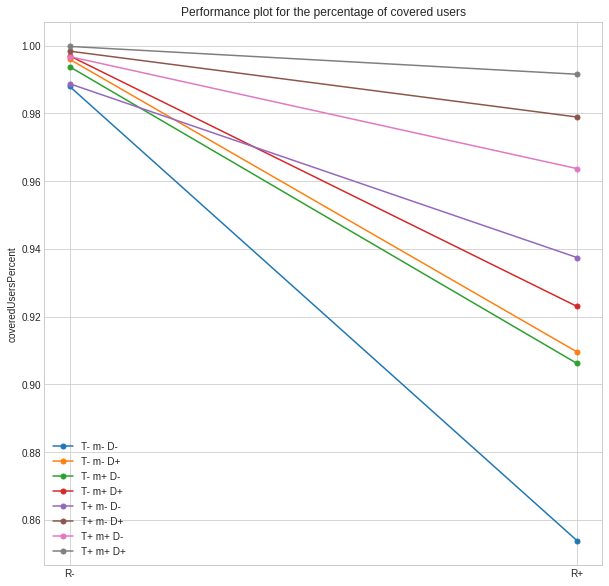

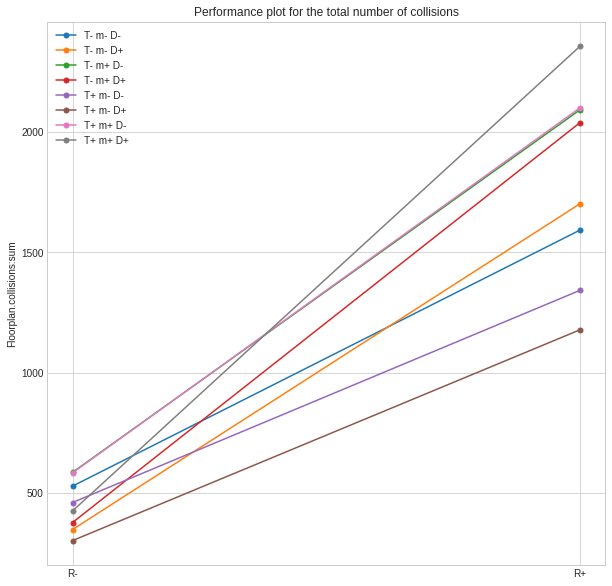

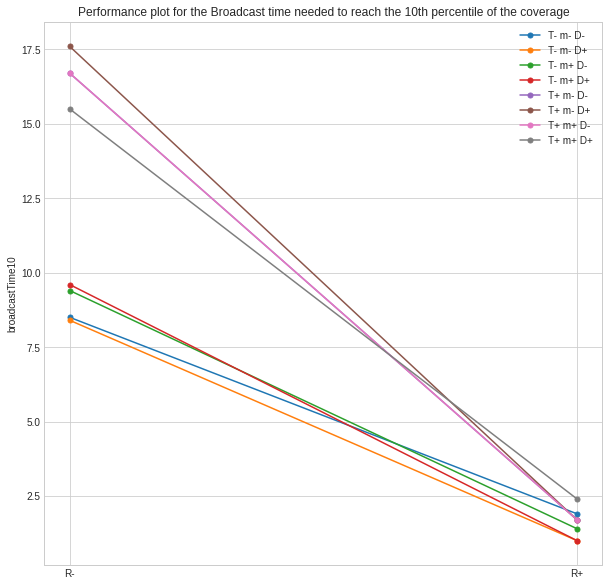

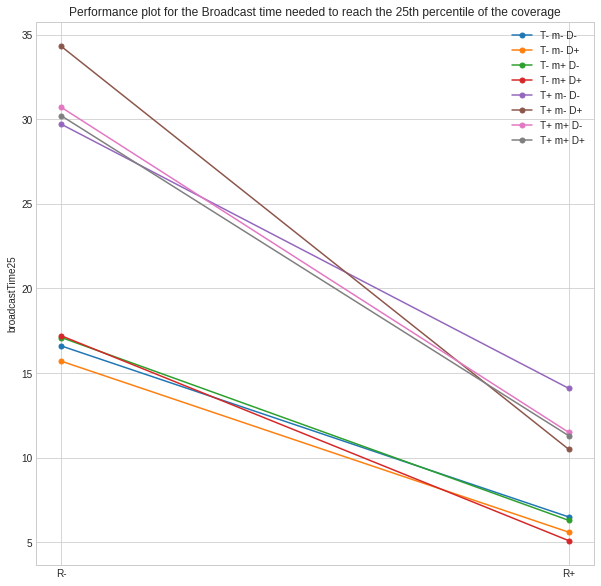

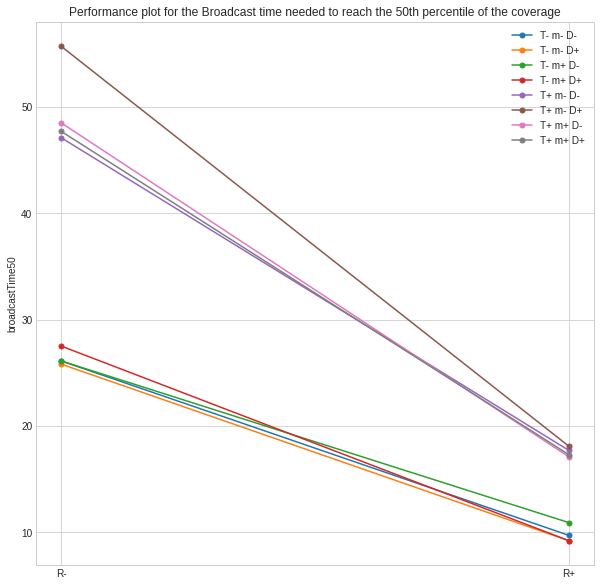

In [9]:
xarr = np.array([-1, 1])
idx = 0
for perfIndex, perfIndexDesc in perfIndexes:
    if perfIndex in skipped:
        continue
    ys = []
    es = []
    fs = []
    for cfg in range(0, configsCount):
        y = np.sum(factorsMatrix.loc[cfg, ['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
        highy = np.sum(factorsMatrix.loc[cfg, combinedFactors].values * ciMatrices[idx].loc['CI+ Qi ({:.2%})'.format(tIntervalAlpha), combinedFactors].values)
        _, positiveInterval = tuple(v*math.sqrt(errorVariances[idx]/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
        q0 = computeMatrices[idx].loc['Mean (Qi)']['I']
        highy += q0 + positiveInterval
        fs.append(' '.join([f + str('+' if factorsMatrix.loc[cfg][f] == 1 else '-') for f in factors[1:]]))
        ys.append(y)
        es.append(highy - y)

    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.xticks(xarr, (factors[0] + '-', factors[0] + '+'))
    ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
    es = [e for e in zip(es[:configsCount//2], es[configsCount//2:])]
    for y, e, lbl in zip(ys, es, fs):
        yarr = np.array(y)
        earr = np.array(e)
        if plotErrorBars:
            plt.errorbar(x=xarr, y=yarr, yerr=earr, capsize=3, linestyle='-', marker='.', markersize=10, label=lbl)
        else:
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
    plt.title('Performance plot for the ' + perfIndexDesc)
    plt.ylabel(perfIndex)
    plt.legend()
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-perfplot.png')
    plt.show()
    idx += 1